In [20]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [84]:
#clase para los individuos del problema de QAP

class QAP:
    def __init__(self, distancias, flujos):
        self.distancias = distancias
        self.flujos = flujos

    def evaluate(self, permutacion):
        n = len(permutacion)
        suma = 0
        for i in range(n):
            for j in range(i + 1, n):
                suma += self.flujos[i, j] * self.distancias[permutacion[i] - 1,permutacion[j] - 1]
        return suma

In [70]:

#funcion de lectura de archivos
def leerArchivo(nombre):
    with open(nombre, 'r') as archivo:
        lines = archivo.readlines()

    # Leer el número de variables
    nInstalaciones = int(lines[0].strip())

    # Leer la matriz de flujos
    matrizF = []
    for i in range(nInstalaciones):
        matrizF.append(list(map(int, lines[2 + i].strip().split())))

    # Leer la matriz de distancias
    matrizD = []
    for i in range(nInstalaciones):
        matrizD.append(list(map(int, lines[3 + nInstalaciones + i].strip().split())))
    archivo.close()
    return nInstalaciones, matrizF, matrizD




In [160]:
def GA(QAP, population_size, mutation_rate, generations):
    def generarPoblacionInicial(size):
        return [np.random.permutation(len(QAP.distancias)) for _ in range(size)]

    def evaluar(poblacion):
        return [QAP.evaluate(individual) for individual in poblacion]

    def SeleccionarPadres(poblacion, fitness):
        fitness_sum = sum(fitness)
        if fitness_sum == 0:
            return random.choices(poblacion, k=len(poblacion))
       # Calcular las probabilidades inversas del fitness para dar mayor probabilidad a los valores menores
        fitness_probs = [1 / f for f in fitness]
    
    # Normalizar probabilidades para que sumen 1
        sum_probs = sum(fitness_probs)
        fitness_probs = [p / sum_probs for p in fitness_probs]
    
    # Seleccionar padres con las probabilidades calculadas
        selected = random.choices(poblacion, weights=fitness_probs, k=len(poblacion))
        return selected

    def crossover(parent1, parent2):
        #cut = np.random.randint(1, len(parent1)-1)
        #tamano = len(parent1)
        #child1 = parent1[:cut].tolist() # convertir a lista desde un array de numpy
        
       # i = 0
        #largo = len(child1)
        #while i < tamano:
            
            #print("largo child1\n",len(child1))
         #   j = 0
          #  igual = 1
           # while j < largo:
            #    if parent2[i] == child1[j]:
             #       igual = 2
              #      j = largo + 3
               # j = j+1
                #if j == len(parent1):
                 #   igual = 2
                  #  break
         #   if igual == 1:
          #      child1.append(parent2[i])
           # i = i+1
            



        #child1 = np.array(child1)
        #print(len(child1))

        cut = np.random.randint(1, len(parent1) - 1)
        child1 = np.zeros_like(parent1)
        child2 = np.zeros_like(parent2)
        
        # Generate child1
        used = set(parent1[:cut])
        child1[:cut] = parent1[:cut]
        j = cut
        for item in parent2:
            if item not in used:
                child1[j] = item
                j += 1
                if j == len(parent1):
                    break

        used = set(parent2[:cut])
        child2[:cut] = parent2[:cut]
        j = cut
        for item in parent1:
            if item not in used:
                child2[j] = item
                j += 1
                if j == len(parent2):
                    break
        
        return child1, child2



        #child2 = np.concatenate([parent2[:cut], parent1[cut:]])
        #return child1, child2

    def mutate(individual):
        i, j = np.random.randint(0, len(individual), size=2)
        individual[i], individual[j] = individual[j], individual[i]

    population = generarPoblacionInicial(population_size)
    fitness = evaluar(population)
    best_fitness = []
    best_fitness.append(min(fitness))
    for _ in range(generations):
        selected_parents = SeleccionarPadres(population, fitness)
        next_population = []

        for i in range(0, len(selected_parents), 2):

            child1, child2 = crossover(selected_parents[i], selected_parents[i+1])
            
            if random.random() < mutation_rate:
                mutate(child1)
            if random.random() < mutation_rate:
                mutate(child2)

            next_population.extend([child1, child2])

        fitness = evaluar(next_population)
        population = next_population
        best_fitness.append(min(fitness))
    best_individual = population[np.argmin(fitness)]
    #best_fitness = min(fitness)
    return best_individual, best_fitness

In [71]:
nArchivo = input('Ingrese nombre del archivo de QAP: ')

# Lectura matrices
nInstalaciones,matrizF,matrizD, = leerArchivo(nArchivo)


print(f"Cantidad de Instalaciones: {nInstalaciones}")
print("Matriz de flujos:")
for row in matrizF:
    print(row)
print("Matriz de distancias:")
for row in matrizD:
    print(row)


matrizD2 = np.array(matrizD)
matrizF2 = np.array(matrizF)

Cantidad de Instalaciones: 26
Matriz de flujos:
[53, 67, 66, 66, 66, 53, 53, 53, 53, 53, 73, 53, 53, 53, 66, 53, 53, 53, 53, 85, 73, 73, 73, 73, 53, 53]
[66, 53, 66, 66, 66, 53, 53, 53, 53, 53, 53, 73, 53, 53, 66, 53, 53, 53, 53, 73, 85, 73, 73, 73, 53, 53]
[66, 66, 53, 66, 66, 53, 53, 53, 53, 53, 53, 53, 73, 53, 66, 53, 53, 53, 53, 73, 73, 85, 73, 73, 53, 53]
[66, 66, 66, 53, 66, 53, 53, 53, 53, 53, 53, 53, 53, 73, 73, 53, 53, 53, 53, 73, 73, 73, 85, 85, 53, 53]
[66, 66, 66, 66, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 73, 53, 53, 53, 53, 73, 73, 73, 85, 85, 53, 53]
[53, 53, 53, 53, 53, 53, 66, 66, 66, 66, 53, 53, 53, 53, 53, 73, 73, 53, 53, 53, 53, 53, 53, 53, 85, 85]
[53, 53, 53, 53, 53, 66, 53, 66, 66, 66, 53, 53, 53, 53, 53, 73, 73, 53, 53, 53, 53, 53, 53, 53, 85, 85]
[53, 53, 53, 53, 53, 66, 66, 53, 66, 66, 53, 53, 53, 53, 53, 66, 53, 73, 53, 53, 53, 53, 53, 53, 73, 73]
[53, 53, 53, 53, 53, 66, 66, 66, 53, 66, 53, 53, 53, 53, 53, 66, 53, 53, 73, 53, 53, 53, 53, 53, 73, 73]
[53, 53

In [195]:
instanciaQAP = QAP(matrizD2, matrizF2)
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 100, 0.01, 2000)
print("Mejor solución:", mejorSoluciones)
print("Costo de la mejor solución:", mejoresCostos)

Mejor solución: [16  7 21  8 11  3  9 22 19 23 20 13 12 17 25  1 15  6 24 10  4 14  0 18
  5  2]
Costo de la mejor solución: [2338197, 2500026, 2389399, 2395245, 2395377, 2335885, 2335885, 2324751, 2375677, 2477844, 2412682, 2436743, 2438820, 2447178, 2424503, 2544973, 2458552, 2519529, 2538922, 2509431, 2500895, 2552067, 2432972, 2447704, 2475608, 2542863, 2492103, 2487508, 2522888, 2569437, 2490108, 2482260, 2455548, 2455548, 2518572, 2518874, 2458866, 2500748, 2516926, 2528271, 2497528, 2496439, 2479875, 2516828, 2490339, 2452963, 2490493, 2499243, 2511095, 2505175, 2477923, 2502114, 2439803, 2433487, 2469976, 2469976, 2471237, 2505156, 2495148, 2508435, 2528134, 2478824, 2450846, 2485498, 2427723, 2427723, 2463256, 2466856, 2483762, 2510513, 2426324, 2441386, 2422900, 2474921, 2463701, 2414352, 2442416, 2398523, 2386959, 2427042, 2418602, 2419154, 2418602, 2404456, 2428523, 2428523, 2407285, 2422685, 2406129, 2406129, 2418339, 2412620, 2414326, 2414326, 2392903, 2330740, 2330740, 2

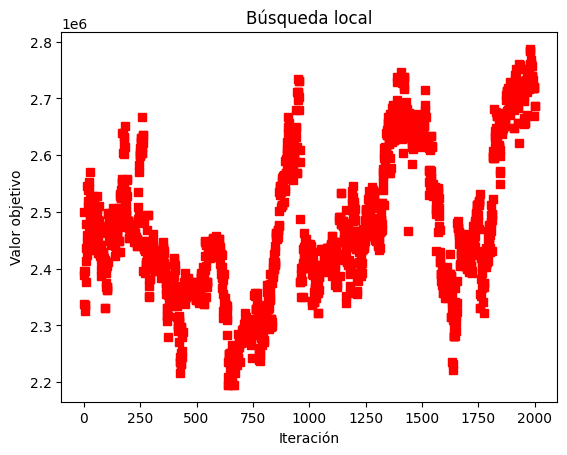

True

In [197]:
def graficar(valoresObjetivo):
    '''    
    Función que grafica la convergencia del valor objetivo
    '''
    grafico = plt.plot(valoresObjetivo)
    plt.setp(grafico,"linestyle","none","marker","s","color","r")
    plt.title(u"Búsqueda local") 
    plt.ylabel(u"Valor objetivo")
    plt.xlabel(u"Iteración")
    plt.show()
    return True

graficar(mejoresCostos)